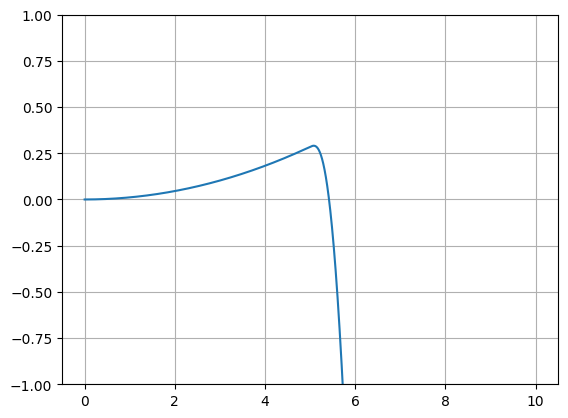

In [6]:
import casadi as ca
import cyecca
import numpy as np
import sympy.physics.mechanics as mech
import sympy.physics.control
import matplotlib.pyplot as plt

import cyecca.lie


def derive_model():
    n_motor = 4

    # p, parameters
    tau_up = ca.SX.sym("tau_up")
    tau_down = ca.SX.sym("tau_down")
    kv = ca.SX.sym("kv")
    dir_motor = ca.SX.sym("dir_motor", n_motor)
    l_motor = ca.SX.sym("l_motor", n_motor)
    theta_motor = ca.SX.sym("theta_motor", n_motor)
    ct = ca.SX.sym("ct")
    cm = ca.SX.sym("cm")
    g = ca.SX.sym("g")
    J_x = ca.SX.sym("J_x")
    J_y = ca.SX.sym("J_y")
    J_z = ca.SX.sym("J_z")
    m = ca.SX.sym("m")
    J = ca.diag(ca.vertcat(J_x, J_y, J_z))  ## assuming symmetrical
    p = ca.vertcat(
        tau_up,
        tau_down,
        kv,
        dir_motor,
        l_motor,
        theta_motor,
        ct,
        cm,
        g,
        m,
        J_x,
        J_y,
        J_z,
    )
    p_defaults = {
        "tau_up": 0.1,
        "tau_down": 0.5,
        "kv": 850,
        "dir_motor_0": 1,
        "dir_motor_1": 1,
        "dir_motor_2": -1,
        "dir_motor_3": -1,
        "l_motor_0": 1,
        "l_motor_1": 1,
        "l_motor_2": 1,
        "l_motor_3": 1,
        "theta_motor_0": np.pi / 4,
        "theta_motor_1": -3 * np.pi / 4,
        "theta_motor_2": -np.pi / 4,
        "theta_motor_3": 3 * np.pi / 4,
        "ct": 1e-5,
        "cm": 1e-8,
        "g": 9.8,
        "m": 1.0,
        "J_x": 1,
        "J_y": 1,
        "J_z": 1,
    }

    # x, state
    state_normalized_motor = ca.SX.sym("state_normalized_motor", n_motor)
    state_omega_wb_b = ca.SX.sym("omega_wb_b", 3)
    state_quaternion_wb = ca.SX.sym("quaternion_wb", 4)
    state_velocity_w_p_b = ca.SX.sym("velocity_w_p_b", 3)
    state_position_op_w = ca.SX.sym("state_position_op_w", 3)

    x = ca.vertcat(
        state_normalized_motor,
        state_omega_wb_b,
        state_quaternion_wb,
        state_velocity_w_p_b,
        state_position_op_w,
    )

    x0_defaults = {
        "state_normalized_motor_0": 0,
        "state_normalized_motor_1": 1,
        "state_normalized_motor_2": 2,
        "state_normalized_motor_3": 3,
        "state_omega_wb_b_0": 0,
        "state_omega_wb_b_1": 0,
        "state_omega_wb_b_2": 0,
        "state_quaternion_wb_0": 1,
        "state_quaternion_wb_1": 0,
        "state_quaternion_wb_2": 0,
        "state_quaternion_wb_3": 0,
        "state_velocity_w_p_b_0": 0,
        "state_velocity_w_p_b_1": 0,
        "state_velocity_w_p_b_2": 0,
        "state_position_op_w_0": 0,
        "state_position_op_w_1": 0,
        "state_position_op_w_2": 0,
    }

    # u, input
    command_normalized_motors = ca.SX.sym("command_normalized_motors", n_motor)
    u = ca.vertcat(command_normalized_motors)

    # motor first order model
    tau = ca.if_else(
        command_normalized_motors - state_normalized_motor > 0, tau_up, tau_down
    )
    derivative_normalized_motors = (
        -1 / tau * (state_normalized_motor - command_normalized_motors)
    )
    state_omega_motors = kv * state_normalized_motor

    # sum of forces and moments
    # xAxis = ca.vertcat(1, 0, 0)
    # yAxis = ca.vertcat(0, 1, 0)
    zAxis = ca.vertcat(0, 0, 1)

    R_wb = cyecca.lie.SO3Quat.elem(state_quaternion_wb)

    F_b = R_wb.to_Matrix().T @ (-m * g * zAxis)  # gravity
    M_b = ca.vertcat(0, 0, 0)
    for i in range(n_motor):
        Fi_b = ct * state_omega_motors[i] ** 2 * zAxis
        ri_b = l_motor[i] * ca.vertcat(
            ca.cos(theta_motor[i]), ca.sin(theta_motor[i]), 0
        )
        Mi_b = (
            ca.cross(ri_b, Fi_b)
            + cm * dir_motor[i] * state_omega_motors[i] ** 2 * zAxis
        )
        F_b += Fi_b
        M_b += Mi_b

    # kinematics
    derivative_omega_wb_b = ca.inv(J) @ (
        M_b - ca.cross(state_omega_wb_b, J @ state_omega_wb_b)
    )
    derivative_quaternion_wb = (
        cyecca.lie.SO3Quat.elem(state_quaternion_wb).right_jacobian() @ state_omega_wb_b
    )
    derivative_position_op_w = R_wb @ state_velocity_w_p_b
    derivative_velocity_w_p_b = F_b / m - ca.cross(
        state_omega_wb_b, state_velocity_w_p_b
    )

    # state derivative vector
    x_dot = ca.vertcat(
        derivative_normalized_motors,
        derivative_omega_wb_b,
        derivative_quaternion_wb,
        derivative_velocity_w_p_b,
        derivative_position_op_w,
    )
    f = ca.Function("f", [x, u, p], [x_dot])

    # setup integrator
    dae = {"x": x, "ode": f(x, u, p), "p": p, "u": u}

    p_index = {p[i].name(): i for i in range(p.shape[0])}
    x_index = {x[i].name(): i for i in range(x.shape[0])}

    return locals()


model = derive_model()


def sim(model, t, u, x0=None, p=None, plot=True):
    x0_dict = model["x0_defaults"]
    if x0 is not None:
        for k in x0.keys():
            if not k in x0_dict.keys():
                raise KeyError(k)
            x0_dict[k] = x0[k]
    p_dict = model["p_defaults"]
    if p is not None:
        for k in p.keys():
            if not k in p_dict.keys():
                raise KeyError(k)
            p_dict[k] = p[k]
    dae = model["dae"]
    f_int = ca.integrator("test", "idas", dae, t[0], t)
    return f_int(x0=x0_dict.values(), z0=0, p=p_dict.values(), u=u)


t = np.arange(0, 10, 0.001)
T_max = 0.583
t_off = 5
u_sim = np.vstack(
    [
        np.where(t < t_off, T_max, 0),
        np.where(t < t_off, T_max, 0),
        np.where(t < t_off, T_max, 0),
        np.where(t < t_off, T_max, 0),
    ]
)
res = sim(
    model,
    t,
    u_sim,
    {
        "state_normalized_motor_0": T_max,
        "state_normalized_motor_1": T_max,
        "state_normalized_motor_2": T_max,
        "state_normalized_motor_3": T_max,
    },
)

plt.plot(t, res["xf"].T[:, model["x_index"]["state_position_op_w_2"]])
plt.ylim([-1, 1])
plt.grid()

In [2]:
%%timeit
res = sim(
    model,
    t,
    u_sim,
    {
        "state_normalized_motor_0": T_max,
        "state_normalized_motor_1": T_max,
        "state_normalized_motor_2": T_max,
        "state_normalized_motor_3": T_max,
    },
)

14 ms ± 41.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
